In [1]:
from ferc_xbrl_extractor.cli import TAXONOMY_MAP
import pandas as pd
from ferc_xbrl_extractor.xbrl import get_fact_tables
from pathlib import Path
from stringcase import snakecase
from collections import Counter
import itertools

Load dataframe of lost facts, and parse taxonomy.

In [2]:
df = pd.read_pickle("../lost_facts.pickle")

tmp_path="./"
tables = get_fact_tables(
    taxonomy_path=TAXONOMY_MAP[1],
    form_number=1,
    db_path="path",
    metadata_path=Path(tmp_path) / "metadata.json",
)

From preliminary analysis, I found there were cases where `utility_type_axis` was missing from the context of a fact that otherwise would have ended up in a table. After checking FERC's rendering of filings [here](https://elibrary.ferc.gov/eLibrary/search), it seems like they treat these facts as totals across utility types.

To see how common a pattern this is, look for all cases where a fact would end up in a table, but it is missing one or more axes (for this to be true, the fact cannot have extra axes beyond those defined for the table.

In [15]:
missing_axes = []
for idx, row in df.iterrows():
    dims = set([snakecase(dim[0]) for dim in row.dimensions])
    missing_axes.append(
        [(name, tuple(set(tables[name].axes) - dims)) for name in row.table_candidates if dims <= set(tables[name].axes)]
    )

print(f"Number of missing facts that definitely don't conform to the pattern: {missing_axes.count([])}")

Number of missing facts that definitely don't conform to the pattern 3253


Now check how many of these "non-conforming" facts don't have any `table_candidates`. Facts with no table candidates are facts whose name does not match any columns in any tables.

In [17]:
print(f"Number of missing facts with no table candidates: {df.table_candidates.apply(lambda cands: not cands).sum()}")

Number of missing facts with no table candidates: 2368


About 2/3 of the "non-conforming" facts simply don't have any table candidates. It seems likely that these facts with no table candidates may contain spelling errors, or some other filing error. Given that the total number of "non-conforming" facts is quite low, and most of them don't have any table candidates, I will ignore these for now, however, they probably should be investigated at some point.

Now look at the combination of table-candidate-name and missing axes to see if there's patterns within these.

In [20]:
c = Counter(itertools.chain.from_iterable(missing_axes))
print(len(c))
c

67


Counter({('taxes_accrued_prepaid_and_charged_during_year_262_duration',
          ('utility_type_axis',)): 28809,
         ('taxes_accrued_prepaid_and_charged_during_year_262_instant',
          ('utility_type_axis',)): 22362,
         ('statement_of_income_114_duration', ('utility_type_axis',)): 21819,
         ('taxes_accrued_prepaid_and_charged_during_year_totals_262_duration',
          ('utility_type_axis',)): 10054,
         ('taxes_accrued_prepaid_and_charged_during_year_totals_262_instant',
          ('utility_type_axis',)): 9520,
         ('summary_of_utility_plant_and_accumulated_provisions_for_depreciation_amortization_and_depletion_200_instant',
          ('utility_type_axis',)): 2227,
         ('distribution_of_salaries_and_wages_other_accounts_354_duration',
          ('type_of_distribution_axis',)): 1993,
         ('distribution_of_salaries_and_wages_354_duration',
          ('type_of_distribution_axis',)): 1891,
         ('accumulated_provision_for_depreciation_of_elect

Clearly there a few table-axes combinations that show up incredibly frequently. In total, there are 67 table-axes combinations that account for all 116,320 missing facts which have at least one table candidate.

I've already spot checked facts missing the `utility_type_axis`, but we should look for other common missing axes and spot check some missing facts.

In [25]:
Counter([missing_axis[1] for missing_axis in itertools.chain.from_iterable(missing_axes)])

Counter({('utility_type_axis',): 96014,
         ('allowance_inventory_time_period_axis',): 6112,
         ('electric_plant_classification_axis',): 4525,
         ('type_of_distribution_axis',): 3884,
         ('month_axis',): 3354,
         ('utility_type_axis', 'taxes_accrued_prepaid_and_charged_axis'): 1504,
         ('utility_type_axis', 'kind_of_tax_axis'): 1504,
         ('investments_in_subsidiary_companies_axis',): 1220,
         ('utility_type_axis', 'non_utility_details_axis'): 968,
         ('utility_type_axis', 'electric_plant_classification_axis'): 961,
         ('functional_classification_axis',): 871,
         ('substations_axis',): 582,
         ('substation_by_functional_character_axis',): 582,
         ('ancillary_services_purchases_and_sales_axis',): 451,
         ('miscellaneous_general_expenses_axis',): 321,
         ('taxes_accrued_prepaid_and_charged_axis',): 264,
         ('kind_of_tax_axis',): 264,
         ('allowance_inventory_time_period_axis',
          'al

The next most common missing axis is `allowance_inventory_time_period_axis`, so lets find some facts to spot check.

In [40]:
idx = [
    any(['allowance_inventory_time_period_axis' in axis[1] for axis in axes])
    for axes in missing_axes
]
df[idx]

,name,entity,start_date,end_date,dimensions,value,table_candidates,period
31,allowance_inventory_number,C008999,None,2020-12-31,"[(EmissionTypeAxis, ferc:SulfurDioxideMember)]",150710,[allowances_accounts_158_1_and_158_2_228a_inst...,instant
32,allowance_inventory_number,C008999,None,2021-12-31,"[(EmissionTypeAxis, ferc:SulfurDioxideMember)]",657766,[allowances_accounts_158_1_and_158_2_228a_inst...,instant
33,allowance_inventory_number,C008999,None,2020-12-31,"[(EmissionTypeAxis, ferc:NitrogenOxideMember)]",154,[allowances_accounts_158_1_and_158_2_228a_inst...,instant
34,allowance_inventory,C008999,None,2020-12-31,"[(EmissionTypeAxis, ferc:NitrogenOxideMember)]",46554,[allowances_accounts_158_1_and_158_2_228a_inst...,instant
35,allowance_inventory_number,C008999,None,2021-12-31,"[(EmissionTypeAxis, ferc:NitrogenOxideMember)]",12460,[allowances_accounts_158_1_and_158_2_228a_inst...,instant
...,...,...,...,...,...,...,...,...
160091,allowances_relinquished_other_number,C000500,2021-01-01,2021-12-31,"[(EmissionTypeAxis, ferc:SulfurDioxideMember),...",32645,[allowances_accounts_158_1_and_158_2_228a_dura...,duration
160092,allowances_relinquished_other,C000500,2021-01-01,2021-12-31,"[(EmissionTypeAxis, ferc:SulfurDioxideMember),...",0,[allowances_accounts_158_1_and_158_2_228a_dura...,duration
160094,allowances_relinquished_other_description,C000500,2021-01-01,2021-12-31,"[(EmissionTypeAxis, ferc:NitrogenOxideMember),...",EPA Consent Decree Surrender,[allowances_accounts_158_1_and_158_2_228a_dura...,duration
160095,allowances_relinquished_other_number,C000500,2021-01-01,2021-12-31,"[(EmissionTypeAxis, ferc:NitrogenOxideMember),...",4737,[allowances_accounts_158_1_and_158_2_228a_dura...,duration


To spot check these, I found that the entity ID: `C008999` corresponds with Entergy Mississippi, so I found their 2021 filing on the link above and went to page 228, as this corresponds to the table `allowances_accounts_158_1_and_158_2_228a_instant`. It can be seen here that the value is presented in FERC's rendering as a total. 

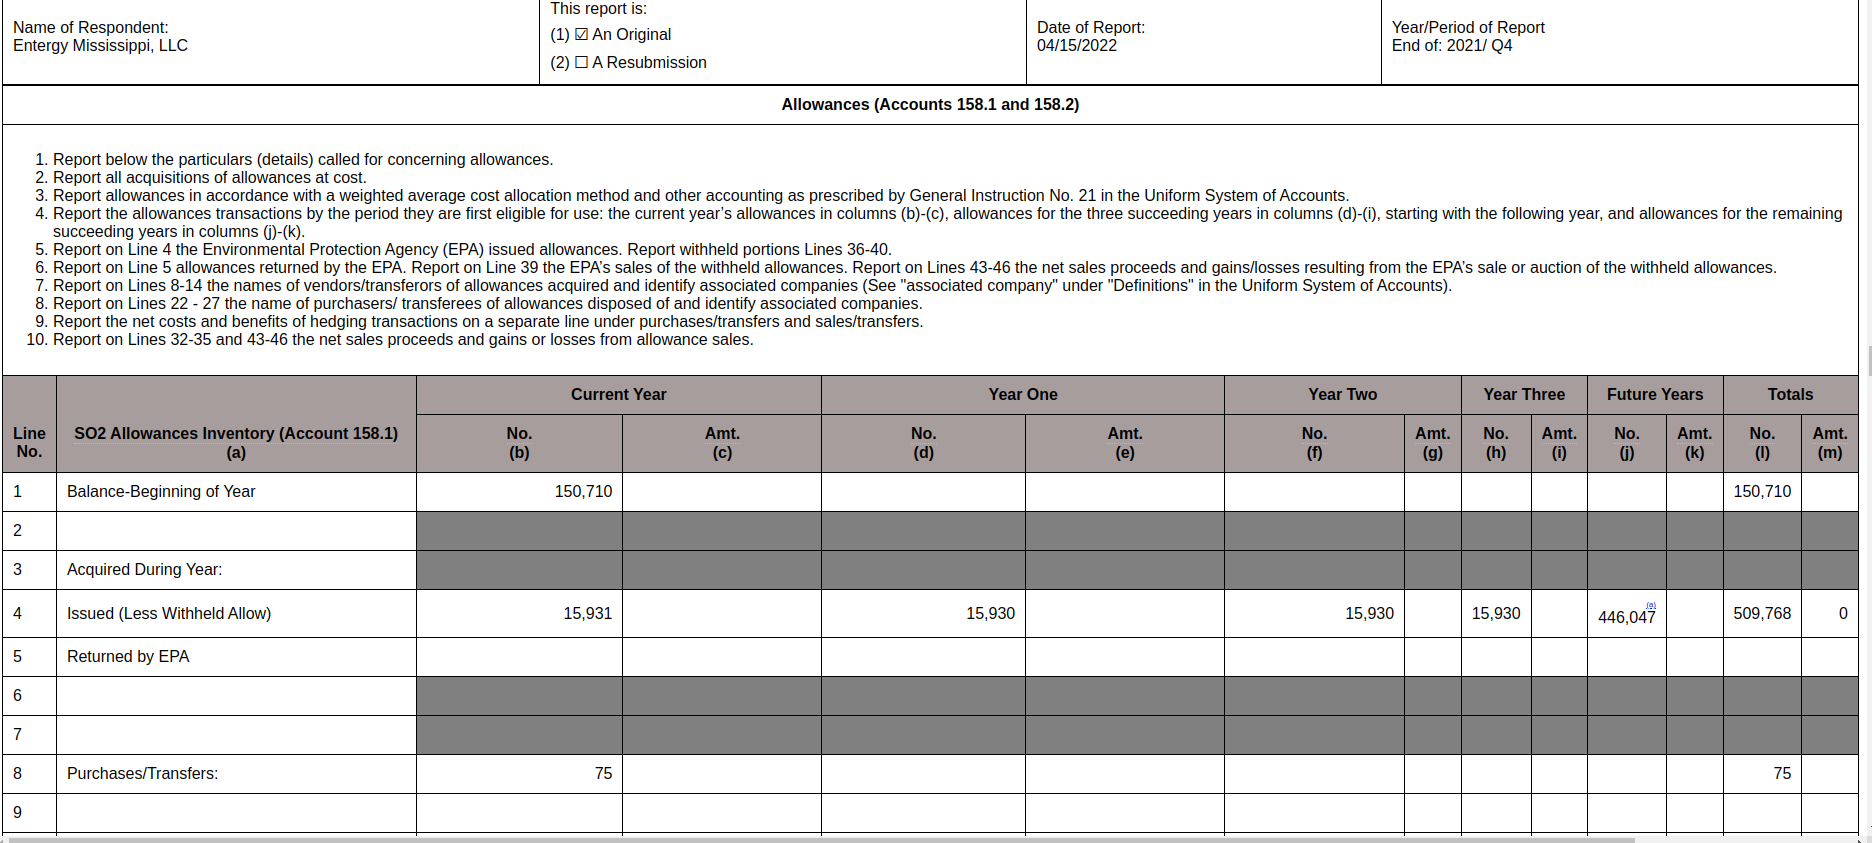

I next looked at several other facts shown above, including several with the entity ID `C000500` (Wisconsin Public Service Corporation). In all of these cases, the values are being presented as totals.

Now looking at `electric_plant_classification_axis`:

In [42]:
idx = [
    any(['electric_plant_classification_axis' in axis[1] for axis in axes])
    for axes in missing_axes
]
df[idx].loc[160220]

name                                           depreciation_provision
entity                                                        C000500
start_date                                                 2021-01-01
end_date                                                   2021-12-31
dimensions            [(UtilityTypeAxis, ferc:ElectricUtilityMember)]
value                                                       130674370
table_candidates    [accumulated_provision_for_depreciation_of_ele...
period                                                       duration
Name: 160220, dtype: object

Again see that this value is treated a a total:

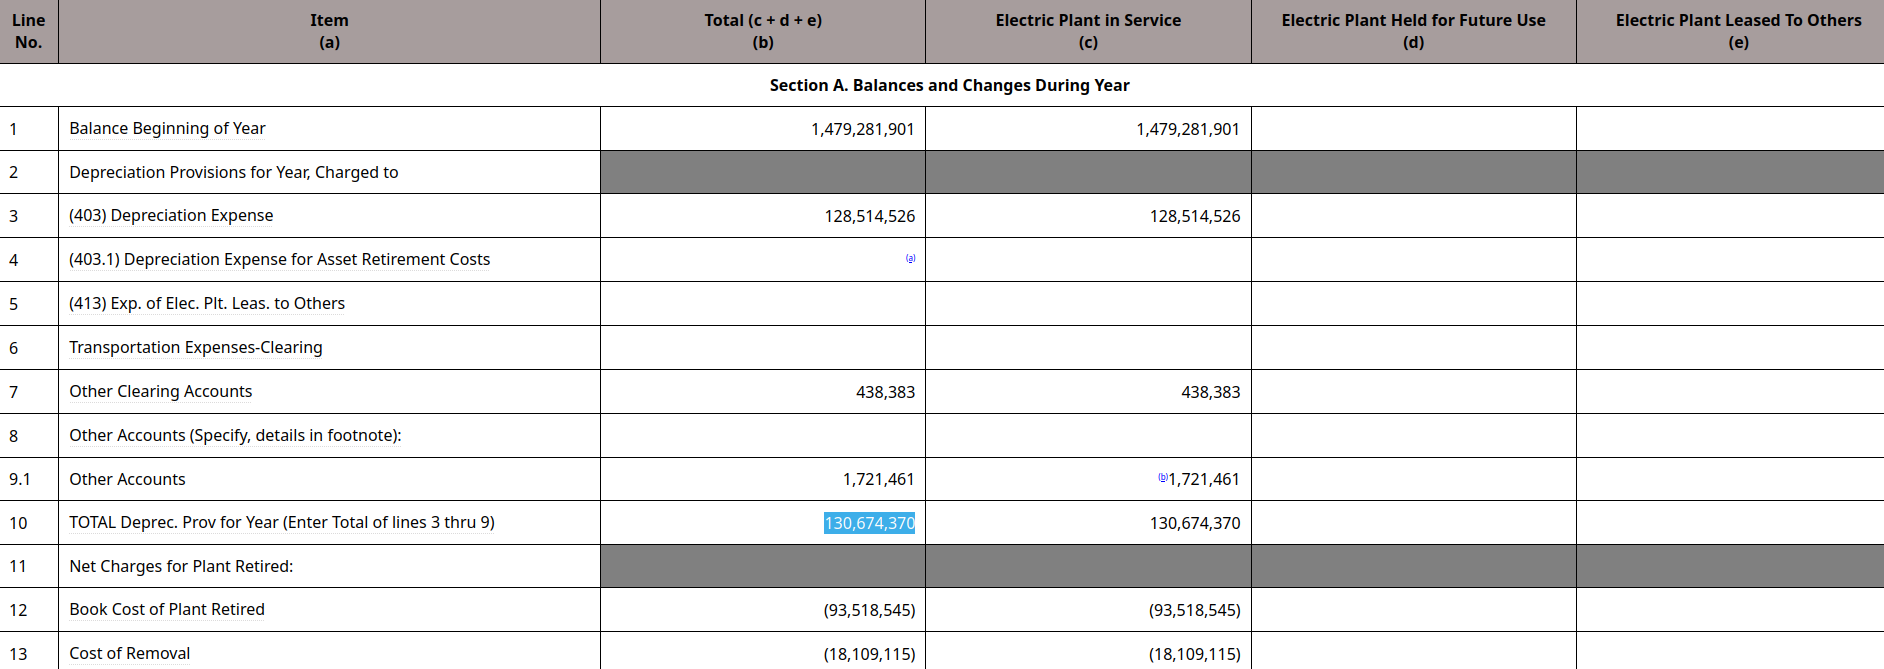

In [46]:
idx = [
    any(['type_of_distribution_axis' in axis[1] for axis in axes])
    for axes in missing_axes
]
df[idx].sample(random_state=1)

,name,entity,start_date,end_date,dimensions,value,table_candidates,period
149611,salaries_and_wages_other_accounts,C000691,2021-01-01,2021-12-31,[(DistributionOfSalariesAndWagesOtherAccountsA...,3199633,[distribution_of_salaries_and_wages_354_durati...,duration
